# Configuring IPython

## Finding configuration options

IPython has many configurable attributes. These can be viewed using the `-h` flag to the command line applications:

In [1]:
!ipython -h

 IPython

Tools for Interactive Computing in Python

    A Python shell with automatic history (input and output), dynamic object
    introspection, easier configuration, command completion, access to the
    system shell and more.  IPython can also be embedded in running programs.

Usage

    ipython [subcommand] [options] [-c cmd | -m mod | file] [--] [arg] ...

    If invoked with no options, it executes the file and exits, passing the
    remaining arguments to the script, just as if you had specified the same
    command with python. You may need to specify `--` before args to be passed
    to the script, to prevent IPython from attempting to parse them. If you
    specify the option `-i` before the filename, it will enter an interactive
    IPython session after running the script, rather than exiting. Files ending
    in .py will be treated as normal Python, but files ending in .ipy can
    contain special IPython syntax (magic commands, shell expansions, etc.).

    Almost all 

This is an important trick for finding out configuration info:
    
    $> ipython [subcommand] --help-all | grep [-C context] PATTERN

`--help-all` exposes everything configurable in IPython,
there is a good chance you will find what you are looking for.

A common configuration question is:

> how do I disable the "Do you really want to exit" message when quitting with `Ctrl-d`?

Well, logically this has to do with `exit`, so let's look for it:

In [2]:
!ipython --help-all | GREP_COLOR='1;31;46' grep --color exit

    If invoked with no options, it executes the file and exits, passing the
    IPython session after running the script, rather than exiting. Files ending
--confirm-exit
    Set to confirm when you try to exit IPython with an EOF (Control-D
    in Unix, Control-Z/Enter in Windows). By typing 'exit' or 'quit',
    you can force a direct exit without any confirmation.
--no-confirm-exit
    Don't prompt the user when exiting.
--TerminalInteractiveShell.confirm_exit=<CBool>
    Set to confirm when you try to exit IPython with an EOF (Control-D in Unix,
    Control-Z/Enter in Windows). By typing 'exit' or 'quit', you can force a
    direct exit without any confirmation.


Which shows me that I can disable the confirmation for a single IPython session with

    $> ipython --no-confirm-exit
    
or I can set the `TerminalInteractiveShell.confirm_exit=False` in a config file,
to have it be the default behavior.

## Configuration principles

Here are the design principles of the IPython configuration system: 

* Configuration is always done using class attributes
* Classes that have configurable attributes are subclasses of `Configurable`
* Attributes that are configurable are typed traitlets objects (`Bool`, `Unicode`, etc.) that have `config=True`
* In config files, configurable attributes can be set using the format `Class.attr_name=the_value`
* At the command line, configurable attributes can be set using the syntax `--Class.attr_name=the_value`
* At the command line, some attributes have shorthands of the form `--attr-name=value`
* Values set at the command line have higher priority than those set in config files

## The IPython Profile

IPython has a notion of 'profiles' - these are directories that live in your IPYTHONDIR,
which contain configuration and runtime information.

Let's create the default profile

In [3]:
!ipython profile create newprofile

[ProfileCreate] WARNING | Generating default config file: u'/Users/minrk/.ipython/profile_newprofile/ipython_config.py'
[ProfileCreate] WARNING | Generating default config file: u'/Users/minrk/.ipython/profile_newprofile/ipython_qtconsole_config.py'
[ProfileCreate] WARNING | Generating default config file: u'/Users/minrk/.ipython/profile_newprofile/ipython_notebook_config.py'


This creates a profile in your IPYTHONDIR (`ipython locate` is a quick way to see where your IPYTHONDIR is),
and populates it with automatically generated default config files.

In [4]:
!ipython locate profile default
!ipython locate profile newprofile

/Users/minrk/.ipython/profile_default
/Users/minrk/.ipython/profile_newprofile


You can skim

In [5]:
profile = get_ipython().profile_dir.location
profile

u'/Users/minrk/Dropbox/dev/ip/pres/ipython-in-depth/profile_euroscipy'

In [6]:
ls $profile

db/                          ipython_config.py            ipython_qtconsole_config.py  pid/                         startup/
history.sqlite               ipython_notebook_config.py   log/                         security/                    static/


Let's peek at our config file

In [7]:
pycat $profile/ipython_config.py

## The %config magic

The `%config` magic lets you do some configuration at runtime, rather than in configuration files.

In [8]:
%matplotlib inline

`%config` with no arguments will show you what configurable objects exist:

In [9]:
%config

Available objects for config:
     ZMQInteractiveShell
     HistoryManager
     PrefilterManager
     AliasManager
     IPCompleter
     PromptManager
     DisplayFormatter
     LaTeXTool
     MagicsManager
     IPKernelApp
     StoreMagics
     InlineBackend


And `%config Class` will show you the config for that class:

In [10]:
%config InlineBackend

InlineBackend options
-------------------
InlineBackend.close_figures=<Bool>
    Current: True
    Close all figures at the end of each cell.
    When True, ensures that each cell starts with no active figures, but it also
    means that one must keep track of references in order to edit or redraw
    figures in subsequent cells. This mode is ideal for the notebook, where
    residual plots from other cells might be surprising.
    When False, one must call figure() to create new figures. This means that
    gcf() and getfigs() can reference figures created in other cells, and the
    active figure can continue to be edited with pylab/pyplot methods that
    reference the current active figure. This mode facilitates iterative editing
    of figures, and behaves most consistently with other matplotlib backends,
    but figure barriers between cells must be explicit.
InlineBackend.figure_format=<CaselessStrEnum>
    Current: 'retina'
    Choices: ['svg', 'png', 'retina']
    The image fo

Most importantly, the `%config` magic can be used to change the value of a configurable attribute at runtime. Here we tell the inline matplotlib backend to use SVG instead of the default PNG

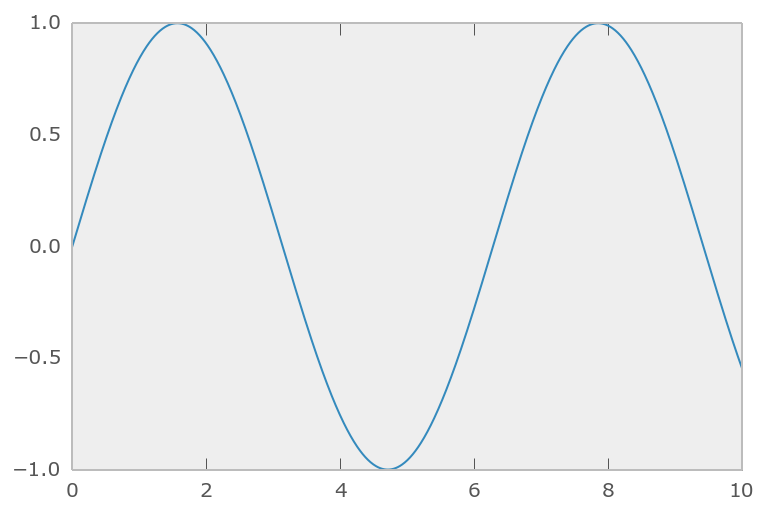

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,10,1000)
y = np.sin(x)
plt.plot(x,y)

In [12]:
%config InlineBackend.figure_format = 'svg'

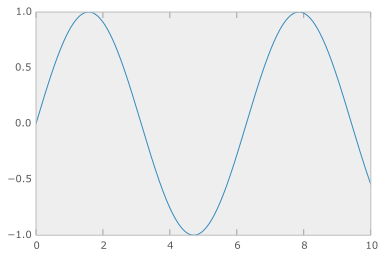

In [13]:
plt.plot(x,y)

## Startup Files

Startup files are simple Python or IPython scripts
that are run whenever you start IPython.
These are a useful way to do super common imports,
or for building database connections to load on startup of a non-default profile.

We can use a startup file to ensure that our `%tic/toc` magics are always defined,
every time we start IPython.

In [14]:
!ls $profile/startup

README


In [15]:
!cat $profile/startup/README

This is the IPython startup directory

.py and .ipy files in this directory will be run *prior* to any code or files specified
via the exec_lines or exec_files configurables whenever you load this profile.

Files will be run in lexicographical order, so you can control the execution order of files
with a prefix, e.g.::

    00-first.py
    50-middle.py
    99-last.ipy


Adding common imports, so we never have to forget them again

In [16]:
%%writefile $profile/startup/simpleimports.py

import sys, os, time, re

Writing /Users/minrk/Dropbox/dev/ip/pres/ipython-in-depth/profile_euroscipy/startup/simpleimports.py


**Restart the kernel** and then run the following cells immediately to verify these scripts have been executed:

In [1]:
sys

<module 'sys' (built-in)>

## Extensions

In [2]:
profile = get_ipython().profile_dir.location

In [3]:
!cat $profile/ipython_config.py | grep InteractiveShellApp.extensions

# c.InteractiveShellApp.extensions = []


In [4]:
!echo "c.InteractiveShellApp.extensions = ['mymagics']" >> $profile/ipython_config.py
!tail $profile/ipython_config.py

# If you want to add script magics that aren't on your path, specify them in
# script_paths
# c.ScriptMagics.script_magics = []

# Dict mapping short 'ruby' names to full paths, such as '/opt/secret/bin/ruby'
# 
# Only necessary for items in script_magics where the default path will not find
# the right interpreter.
# c.ScriptMagics.script_paths = {}
c.InteractiveShellApp.extensions = ['mymagics']


**Restart the kernel** to see the effects:

In [1]:
import time
%tic
time.sleep(0.1)
%toc

101 ms


hello


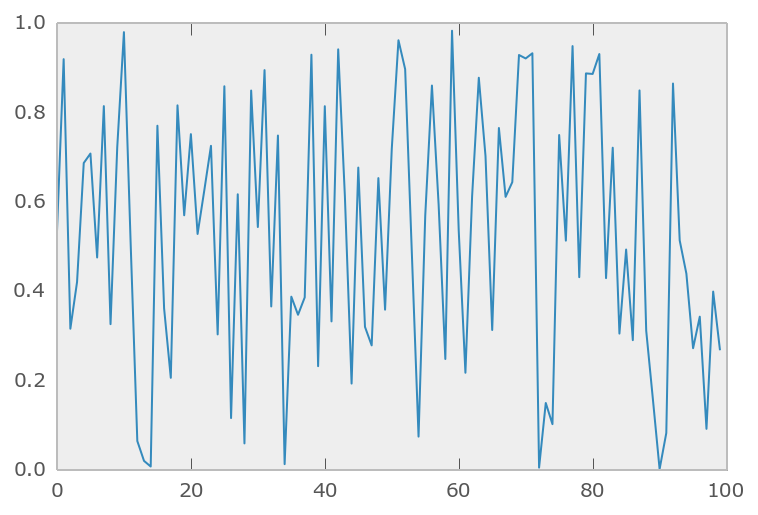

In [2]:
%nbrun Sample